In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.patches import Rectangle

import emcee
import corner
import cmasher as cmr


Bad key "text.kerning_factor" on line 4 in
/home/nitika/miniconda3/envs/py38/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
<ipython-input-1-9db0e39edc96>:5: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
save_plots = False

In [3]:
# constants
Msun = 1.99e33 # g
Rsun = 6.957e10 #cm
yr = 3.15e7 # s
day = 86400 #s
c = 3e10 # cm/s
mp = 1.67e-24 # g
me = 9.1e-28 # g
pc = 3.086e18 # cm
Jy = 1e-23 # cgs
c1 = 6.27e18 # cgs
ev = 1.60218e-12 #erg
G = 6.67259e-8 #cgs
k = 1.380658e-16 # cgs
qe = 4.8e-10 # esu
sigma_t = 6.65e-25 # cm^2

In [4]:
# fixed parameters
eps_e = 0.33
eps_b = 0.33
p = 3

In [5]:
# Model parameters
# progenitor radius, wind velocity, breakout pulse L
model_params = {} 
model_params['RSG'] = [500*Rsun, 20*(1e5), 1e43]
model_params['BSG'] = [70*Rsun, 250*(1e5), 1e44]
model_params['WR'] = [5*Rsun, 1000*(1e5), 1e44]

## Shock Radius and Velocity

In [6]:
def shock_dyn(t, prog_model, Mdot, E, M_ej, n=10, s=2):
    
    Rstar, vw, Lbo = model_params[prog_model]
    
    vo = np.sqrt((10/3)*((n-5)/(n-3))*(E/M_ej))
    pt3 = (M_ej**(5/2))*(E**(-3/2))/((4*np.pi/3)*(n/(n-3))*((10/3)*((n-5)/(n-3)))**(3/2))
    A = pt3*(vo**n)

    B = Mdot/(4*np.pi*vw*(Rstar**(2-s)))
    
    b = ((3-s)*(4-s))/((n-3)*(n-4))
    
    Rc = (b*A/B)**(1/(n-s)) * t**((n-3)/(n-s))
    Vc = (Rc/t)*((n-3)/(n-s))
    
        
    return Rc,Vc

## Calculate lightcurves including only synchrotron self-absorption (SSA)

In [7]:
def SSA_LC(t, nu, prog_model, Mdot, E, M_ej, n=10, s=2):

    # shock radius and velocity
    Rs,Vs = shock_dyn(t, prog_model, Mdot, E, M_ej, n=n, s=s)
    
    Rstar, vw, Lbo = model_params[prog_model]
        
    # Minimum energy and number density scale of relativsitic electron distribution
    rho_CSM = (Mdot/(4*np.pi*vw*(Rstar**2)))*((Rstar/Rs)**(s))
    ne = rho_CSM/mp
    u_tot = (9/8)*rho_CSM*(Vs**2)

    E_min = (eps_e*u_tot/ne)*((p-2)/(p-1))
    No = u_tot*eps_e*(p-2)*(E_min**(p-2))
    
    # magnetic field behind shock
    B = np.sqrt(8*np.pi*u_tot*eps_b)
    
    # calculate nu_cool at every time
    nu_c = (18*np.pi*me*c*qe)/((sigma_t**2) * (B**3) * (t**2))
    
    # calculate nu_a_fast+L_a_fast and nu_a_slow+L_a_slow using eqs in Appendix C of Ho et al 2021
    eta = ((sigma_t/(12*(np.pi**2)*(me**2)*c))**(2/7)) * ((qe/(2*np.pi*me*c))**(1/7))
    zeta = (1/3) * ((2*np.pi*me)**(3/2)) * ((c/qe)**(1/2))
    xi = (sigma_t**2)/(18*np.pi*me*c*qe)
    
    nu_a_fast = (Rs**(1/4)) * (B**(3/4)) * (t**(-1/4)) * (xi**(-1/8)) * (eta**(7/8))
    L_a_fast = 4*np.pi*(Rs**(21/8)) * (B**(11/8)) * (t**(-5/8)) * (xi**(-5/16)) * (eta**(35/16)) * zeta
    
    nu_a_slow = (Rs**(2/7)) * (B**(9/7)) * eta
    L_a_slow = 4*np.pi*(Rs**(19/7)) * (B**(19/7)) * (eta**(5/2)) * zeta
    
    # set nu_a and L_a at each time, determining whether the fast or slow cooling regime is applicable
    nu_a = nu_a_fast*(1*(nu_c<=nu_a_fast)) + nu_a_slow*(1*(nu_c>=nu_a_slow))
    L_a = L_a_fast*(1*(nu_c<=nu_a_fast)) + L_a_slow*(1*(nu_c>=nu_a_slow))
    
    # use C17 of Ho et al 2021 to get L_nu at every time 
    nu_list = np.ones(len(t))*nu
    nu_star = np.maximum(nu_c,nu_a)
    
    L_nu_hi = ((nu_star/nu_a)**(-(p-1)/2)) * ((nu_list/nu_star)**(-p/2))
    L_nu_mid = (nu_list/nu_a)**(-(p-1)/2)
    L_nu_lo = (nu_list/nu_a)**(5/2)
    
    Lv_SSA = L_nu_hi*(1*(nu_list>nu_star)) + L_nu_mid*(1*(nu_a<nu_list) * 1*(nu_list<nu_c)) + L_nu_lo*(1*(nu_list<nu_a))
    Lv_SSA*=L_a
    
    return(Lv_SSA)


## Calculate lightcurves accounting for both SSA and free-free absorption (FFA)

In [8]:
def FFA_LC(t, nu, prog_model, Mdot, Te, E, M_ej, n=10, s=2):
    
    Rs,Vs = shock_dyn(t, prog_model, Mdot, E, M_ej, n=n, s=s)
    Lv_SSA = SSA_LC(t, nu, prog_model, Mdot, E, M_ej, n=n, s=s)
    
    Rstar, vw, Lbo = model_params[prog_model]
          
    ph = 0.2*1e3*ev
    T = Rstar/c
    Q = (Lbo*T/ph)
    
    # calculate R_bo, making sure the radius never exceeds Rbo_max
    Rbo_max = Q*mp*vw*T/Mdot
    Rbo_ = c*t
    Rbo = 1*(Rbo_<Rbo_max)*Rbo_ + 1*(Rbo_>Rbo_max)*Rbo_max
    
    
    # calculate FFA correction to SSA fluxes
    k_FFA = (4.74e-27)*((nu/1e9)**(-2.1))*((Te/1e5)**(-1.35))
    tau_FFA_ = ((Mdot/(4*np.pi*vw*mp))**2)*(k_FFA/3)*((1/Rs**3) - (1/Rbo**3))
    tau_FFA = tau_FFA_*1*(tau_FFA_ > 0)
    Lv_FFA = Lv_SSA*np.exp(-tau_FFA)
    
    return Lv_FFA

## Generate Plots

<ipython-input-12-facbde5c18d5>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


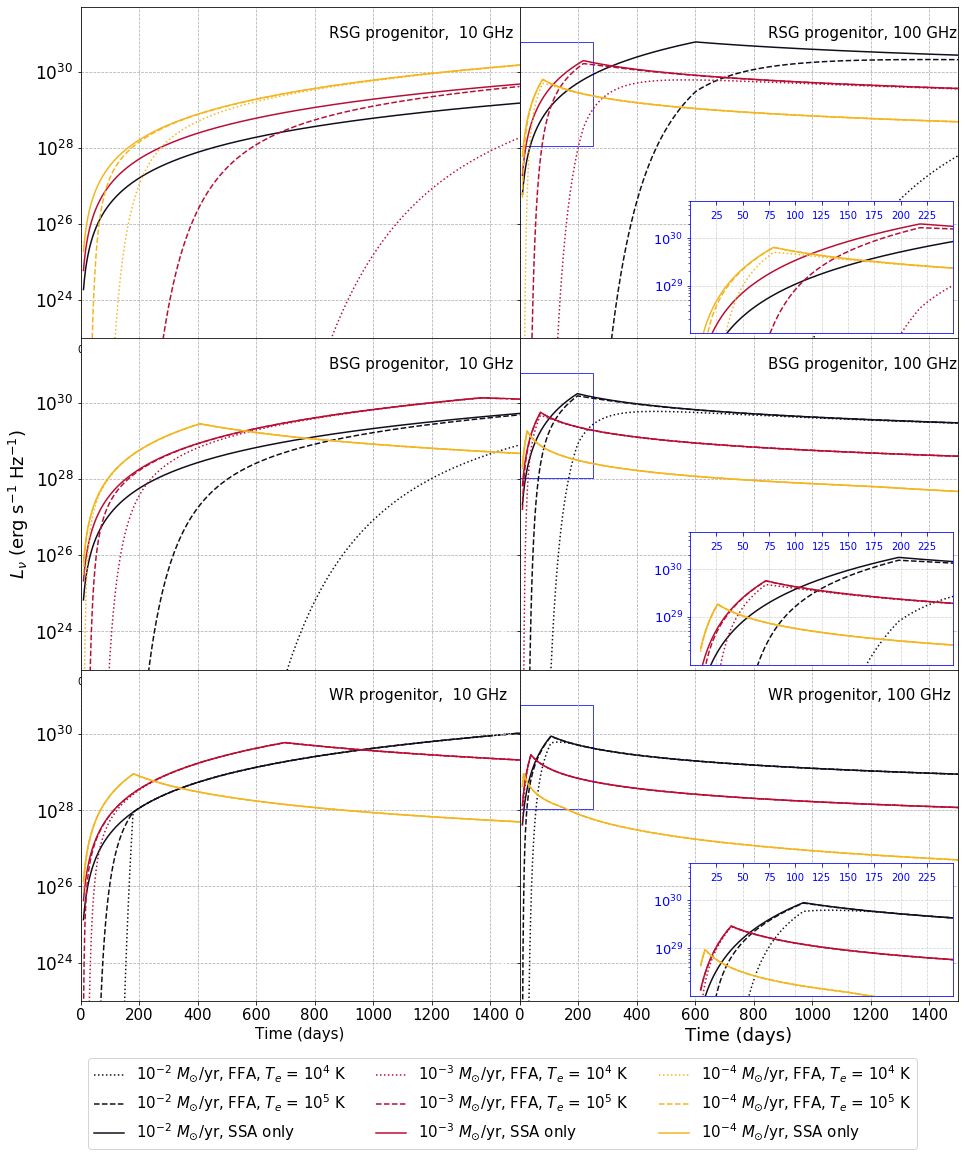

In [12]:
Mdot_list = np.array([1e-2,1e-3,1e-4])*(Msun/yr)
Mdot_labels = ['$10^{-2}\ M_{\odot}$/yr','$10^{-3}\ M_{\odot}$/yr','$10^{-4}\ M_{\odot}$/yr']
Mdot_colors = cmr.ember(np.linspace(0.1, 0.9, 3)) #['r','b','g']

Te_list = [1e4,1e5] # K
Te_labels = ['$10^{4}$ K','$10^{5}$ K']
Te_lines = [':','--']
t = day*np.arange(10,1500+1)

nus = [10e9,100e9]
prog_models = ['RSG','BSG','WR']

E=1e51
M_ej = 5*Msun

fig = plt.figure(figsize=(14,16))
plt_idx = 1
for q in range(len(prog_models)):
    prog_model = prog_models[q]
    
    for k in range(len(nus)):
        nu = nus[k]
        
        ax = fig.add_subplot(320+plt_idx) #plt.subplot(3,2,plt_idx)
        
        for i in range(len(Mdot_list)):
            Mdot = Mdot_list[i]
            color = Mdot_colors[i]

            for j in range(len(Te_list)):
                Te = Te_list[j]

                label = '%s, FFA, $T_{e}$ = %s' %(Mdot_labels[i], Te_labels[j])
                linestyle = Te_lines[j]

                Lv = FFA_LC(t, nu, prog_model, Mdot, Te, E, M_ej, n=10, s=2)
                plt.plot(t/day,np.array(Lv), label=label, color=color, linestyle=linestyle)
                

            label = '%s, %s' %(Mdot_labels[i], 'SSA only')
            Lv_SSA = SSA_LC(t, nu, prog_model, Mdot, E, M_ej, n=10, s=2)
            plt.plot(t/day,np.array(Lv_SSA), label=label,color=color, linestyle='-')
            
        plt.yscale('log')
        plt.ylim([1e23,5e31])
        plt.xlim([0, np.max(t/day)])
        plt.text(850, 8e30, r'%s progenitor, %3.0f GHz' %(prog_model, nu/1e9), fontsize=15, zorder=10)
                    
        if plt_idx in [1,3,5]:
            plt.yticks([1e24,1e26,1e28,1e30],fontsize=17)
            
        if plt_idx in [2,4]:
            plt.xticks(color='w')
            plt.yticks([1e24,1e26,1e28,1e30], color='w')
            
        if plt_idx==3:
            plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=18)
               
        if plt_idx==5:
            plt.xlabel('Time (days)', fontsize=15)
            plt.legend(bbox_to_anchor=(0, -0.15), loc='upper left',fontsize=15, ncol=3)
            plt.xticks(fontsize=15)
            
        if plt_idx==6:
            plt.xlabel('Time (days)', fontsize=18)
            plt.xticks(fontsize=15)
            plt.yticks([1e24,1e26,1e28,1e30], color='w')
            
        plt.grid(axis = 'both', linestyle='--', linewidth=0.75)

            
        if plt_idx in [2,4,6]:
            
            ax.add_patch(Rectangle((1, 1.1e28), 250, 6e30, fill=False, edgecolor = 'blue',lw=0.75))
            
            ax_new = inset_axes(ax, width="60%", height="40%", loc=4)
            for i in range(len(Mdot_list)):
                
                Mdot = Mdot_list[i]
                color = Mdot_colors[i]
                for j in range(len(Te_list)):
                    Te = Te_list[j]
                    linestyle = Te_lines[j]

                    Lv = FFA_LC(t, nu, prog_model, Mdot, Te, E, M_ej, n=10, s=2)
                    plt.plot(t/day,np.array(Lv), color=color, linestyle=linestyle)

                Lv_SSA = SSA_LC(t, nu, prog_model, Mdot, E, M_ej, n=10, s=2)
                plt.plot(t/day,np.array(Lv_SSA), label=label,color=color, linestyle='-')
            
            plt.xlim([0,250])
            plt.ylim([1e28,6e30])
            ax_new.grid(True, linestyle='--', color='lightgrey',linewidth=0.75)
            plt.xticks(np.arange(25,250,25))
            ax_new.xaxis.set_ticks_position('top')
            ax_new.tick_params(axis="x",direction="in", pad=-20, labelsize=10, color='blue', labelcolor='blue')
            
            for spine in ax_new.spines.values():
                spine.set_edgecolor('blue')
            
            plt.yscale('log')
            plt.yticks([1e29, 1e30])
            ax_new.tick_params(axis="y", labelsize=13, color='blue', labelcolor='blue')
            

            
        plt_idx+=1
        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
if save_plots:
    plt.savefig('paper1_figures/IIn_Ibn_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/IIn_Ibn_figure.png',bbox_inches='tight')

In [ ]:
Mdot = 1e-4 * Msun/yr
Te = 1e4
t = day*np.arange(10,800+1)
nu1 = 10e9
nu2 = 100e9
n_list = [8,9,10,11,12]
s_list = [1.6,1.8,2,2.2]
E_list = [5e49,1e50,5e50,1e51]
#Mdot_list = np.array([1e-2,1e-3,1e-4])*(Msun/yr)
prog_model='RSG'
E=1e51
M_ej = 5*Msun

colors = cmr.ember(np.linspace(0.1, 0.85, len(n_list)))
plt.figure(figsize=(8,6))
for i in range(len(n_list)):
    n = n_list[i]
    Lv = FFA_LC(t, nu1, prog_model, Mdot, Te, E, M_ej, n=n, s=2)
    Lv2 = FFA_LC(t, nu2, prog_model, Mdot, Te, E, M_ej, n=n, s=2)
    plt.plot(t/day,Lv, color=colors[i], linestyle='--')
    plt.plot(t/day,Lv2, label='n=%i'%n, color=colors[i], linestyle='-')
    
    
plt.yscale('log')
plt.xlabel('Time (days)',fontsize=15, labelpad=15);
plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=16);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(fontsize=13);
plt.xlim([0,800])
plt.ylim([5e26,1e31])
plt.grid(axis = 'both', linestyle='--', linewidth=0.75)
    
if save_plots:
    plt.savefig('paper1_figures/varyn_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/varyn_figure.png',bbox_inches='tight')


colors = cmr.ember(np.linspace(0.1, 0.85, len(s_list)))
plt.figure(figsize=(8,6))
for i in range(len(s_list)):
    s = s_list[i]
    Lv = FFA_LC(t, nu1, prog_model, Mdot, Te, E, M_ej, n=10, s=s)
    Lv2 = FFA_LC(t, nu2, prog_model, Mdot, Te, E, M_ej, n=10, s=s)
    plt.plot(t/day,Lv, color=colors[i], linestyle='--')
    plt.plot(t/day,Lv2, label='s=%2.1f'%s, color=colors[i], linestyle='-')
    
plt.yscale('log')
plt.xlabel('Time (days)',fontsize=16, labelpad=15);
plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=16)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(fontsize=13);
plt.xlim([0,800])
plt.ylim([5e26,1e31])
plt.grid(axis = 'both', linestyle='--', linewidth=0.75)
if save_plots:
    plt.savefig('paper1_figures/varys_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/varys_figure.png',bbox_inches='tight')


colors = cmr.ember(np.linspace(0.1, 0.85, len(E_list)))
plt.figure(figsize=(8,6))
for i in range(len(E_list)):
        E = E_list[i]        
        Lv = FFA_LC(t, nu1, prog_model, Mdot, Te, E, M_ej, n=10, s=2)
        Lv2 = FFA_LC(t, nu2, prog_model, Mdot, Te, E, M_ej, n=10, s=2)
        plt.plot(t/day,Lv, color=colors[i], linestyle='--')
        plt.plot(t/day,Lv2, label='%1.0e'%E, color=colors[i], linestyle='-')

    
plt.yscale('log')
plt.xlim([0,800])
plt.ylim([5e26,1e31])
plt.xlabel('Time (days)',fontsize=16, labelpad=15);
plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=16)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(fontsize=13);
plt.grid(axis = 'both', linestyle='--', linewidth=0.75)
if save_plots:
    plt.savefig('paper1_figures/varyE_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/varyE_figure.png',bbox_inches='tight')

##  X-band (8.5 GHz) lightcurves of radio detected IIn SNe
Compare lightcurves to previously detected IIn SNe to a range of possible models

In [50]:
t_SN = {}
F = {}
dF = {}
d = {}
t_UL = {}
F_UL = {}

t_SN['2006jd'] = np.array([404.74,511.69,573.61, 581.46, 794.84, 844.62, 902.48, 1030.13, 1382.13]) #days
F['2006jd'] = np.array([238,305,525,509,1024,1033,1069,770,918])*(1e-6)*Jy
dF['2006jd'] = np.array([38, 46, 50, 42, 42, 23, 71, 50, 37])*(1e-6)*Jy
d['2006jd'] = 79*1e6*pc

t_SN['2005kd'] = np.array([632.5, 1036.4, 1127.1])
F['2005kd'] = np.array([211.06,115.09,155.36])*(1e-6)*Jy
dF['2005kd'] = np.array([43.71,36.69,37.19])*(1e-6)*Jy
d['2005kd'] = 63.2*1e6*pc

t_SN['2010jl'] = np.array([681.71, 794.40, 984.96])
F['2010jl'] = np.array([76.6, 118.8,123])*(1e-6)*Jy
dF['2010jl'] = np.array([20.3, 16.8, 26.8])*(1e-6)*Jy
d['2010jl'] = 49*1e6*pc
t_UL['2010jl'] = np.array([37.6,481.28,516.20,563.03])
F_UL['2010jl'] = np.array([71.1,123,32.1,45.6])

t_SN['2009ip'] = np.array([41, 60])
F['2009ip'] = np.array([72.6, 78.3])*(1e-6)*Jy
dF['2009ip'] = np.array([15.2,21.4])*(1e-6)*Jy
d['2009ip'] = 24*1e6*pc



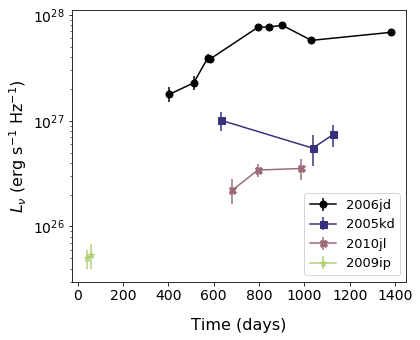

In [51]:
plt.figure(figsize=(6,5))
keys = list(t_SN.keys())
colors = cmr.lilac(np.linspace(0, 0.9, len(t_SN)))
markers = ['o', 's', 'X', '*']
for i in range(len(t_SN)):
    key = keys[i]
    L = F[key]*4*np.pi*(d[key]**2)
    dL = dF[key]*4*np.pi*(d[key]**2)
    plt.errorbar(x=t_SN[key], y = L, yerr = dL, fmt='.-', label=key, color=colors[i], marker=markers[i], markersize=7)
    
plt.yscale('log')
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize=13);
plt.xlabel('Time (days)',fontsize=16, labelpad=15);
plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=16)
if save_plots:
    plt.savefig('paper1_figures/IIn_obs_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/IIn_obs_figure.png',bbox_inches='tight')

## MCMC Analysis of 2006jd

In [52]:
def log_likelihood(theta, t, L, Lerr, prog_model, nu):
    logMdot, logTe, logE, M_ej, n, s = theta
    model = FFA_LC(t, nu, prog_model, 10**logMdot*Msun/yr, 10**logTe, 10**logE, M_ej*Msun, n=n, s=s)
    sigma2 = Lerr ** 2
    return -0.5 * np.sum((L - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    logMdot, logTe, logE, M_ej, n, s = theta
    if not -5.0 <= logMdot <= -1.0:
        return -np.inf
    
    if not 4 <= logTe <= 5:
        return -np.inf

    if not 48 <= logE <= 51:
        return -np.inf
    
    if not 5 <= M_ej <= 10:
        return -np.inf
    
    if not 8 <= n <= 12:
        return -np.inf
    
    if not 1.5 <= s <= 2.5:
        return -np.inf
    
    
    return 0.0

def log_probability(theta, t, L, Lerr, prog_model, nu):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, L, Lerr, prog_model, nu)

In [53]:
init = 0.1*np.random.randn(100,6) + np.array([-4.5, 5, 49, 5.5, 10, 2])
nwalkers,ndim = init.shape

L_06jd = F['2006jd']*4*np.pi*(d['2006jd']**2)
dL_06jd = dF['2006jd']*4*np.pi*(d['2006jd']**2)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t_SN['2006jd']*day, L_06jd, dL_06jd, 'RSG', 8.5e9))

sampler.run_mcmc(init, 3000, progress=True);


  0%|          | 0/3000 [00:00<?, ?it/s]/home/nitika/miniconda3/envs/py38/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:48<00:00, 61.88it/s]


In [54]:
samples = sampler.get_chain()

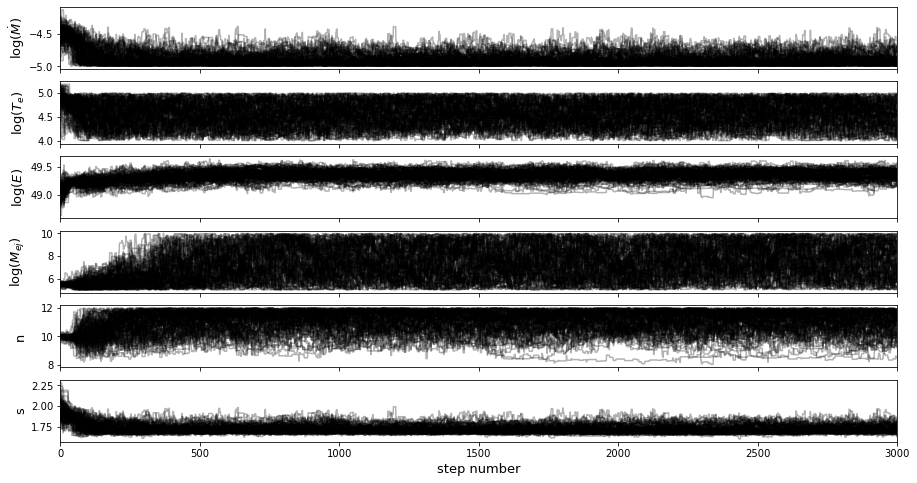

In [55]:
fig, axes = plt.subplots(ndim, figsize=(15,8), sharex=True)
labels = ['log($\dot{M}$)','log($T_{e}$)','log($E$)','log($M_{ej}$)','n','s']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=13)
    ax.yaxis.set_label_coords(-0.04, 0.5)
    
axes[-1].set_xlabel("step number", fontsize=13);


(13300, 6)
(13300, 6)


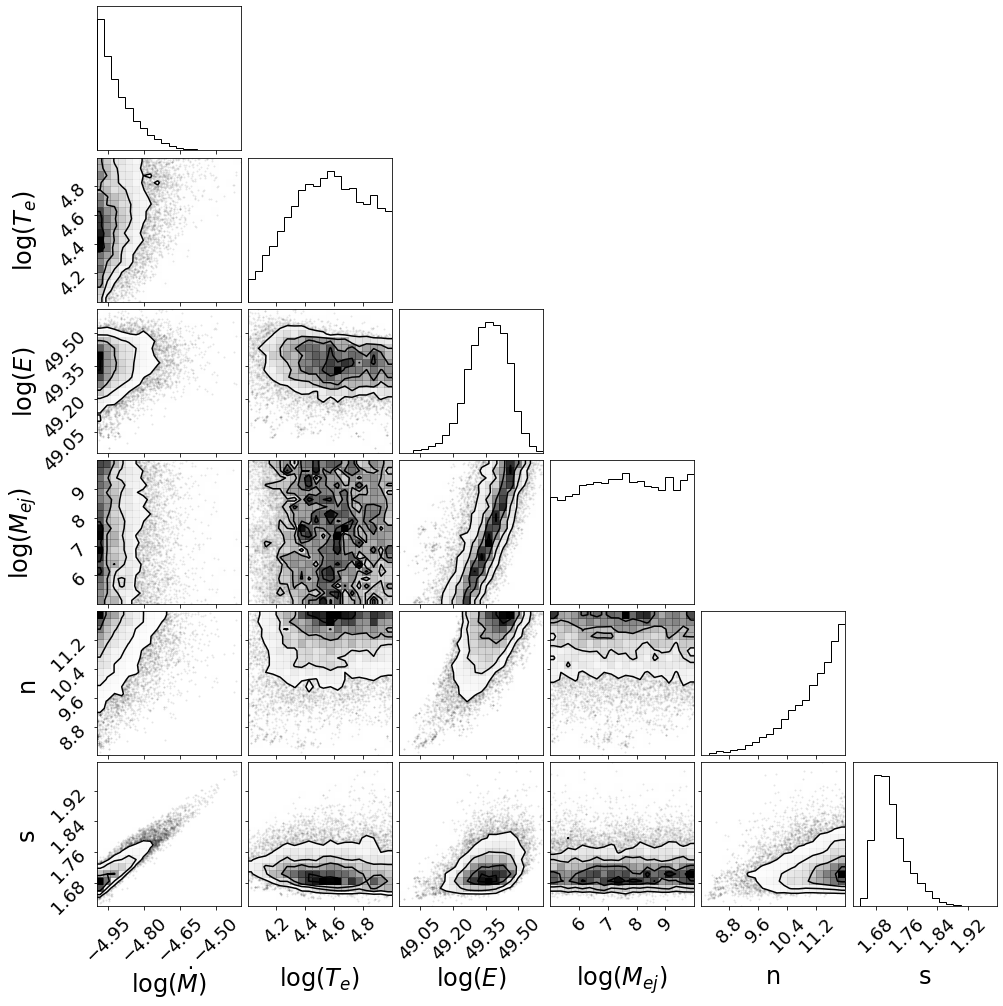

In [56]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

idx_del = []
for i in range(len(flat_samples)):
    if flat_samples[i][-1] < 1.6:
        idx_del.append(i)
        
print(flat_samples.shape)
flat_samples = np.delete(flat_samples, idx_del, 0)
print(flat_samples.shape)


fig = corner.corner(
    flat_samples, labels=labels, label_kwargs={"fontsize":24}, labelpad=0.1
);

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
if save_plots:
    plt.savefig('paper1_figures/2006jd_corner_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/2006jd_corner_figure.png',bbox_inches='tight')

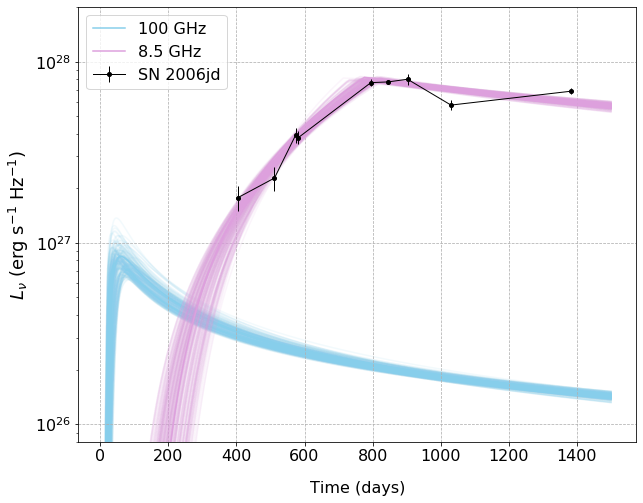

In [57]:
plt.figure(figsize=(10,8))
np.random.seed(0)
inds = np.random.randint(len(flat_samples), size=200)

nu1 = 8.5e9
nu2 = 100e9
prog_model = 'RSG'
t = day*np.arange(10,1500+1)
for ind in inds:
    logMdot, logTe, logE, M_ej, n, s = flat_samples[ind]
    model1 = FFA_LC(t, nu1, prog_model, 10**logMdot*Msun/yr, 10**logTe, 10**logE, M_ej*Msun, n=n, s=s)
    model2 = FFA_LC(t, nu2, prog_model, 10**logMdot*Msun/yr, 10**logTe, 10**logE, M_ej*Msun, n=n, s=s)
    plt.plot(t/day, model1, color='plum', alpha=0.1, zorder=2)
    plt.plot(t/day, model2, color='skyblue', alpha=0.1, zorder=1)
    peaks1.append(t[np.argmax(model1)])
    peaks2.append(t[np.argmax(model2)])

    
plt.plot(t/day, model2, color='skyblue', alpha=1, label='100 GHz',zorder=1)
plt.plot(t/day, model1, color='plum', alpha=1, label='8.5 GHz',zorder=2)

plt.errorbar(x=t_SN['2006jd'],y=L_06jd,yerr=dL_06jd,markersize=8,marker='.',linewidth=1,
             color='black', label='SN 2006jd', zorder=3)
plt.yscale('log')
plt.ylim([8e25,2e28])
plt.xlabel('Time (days)',fontsize=16, labelpad=17);
plt.ylabel(r'$L_{\nu}$ (erg s$^{-1}$ Hz$^{-1}$)', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.legend(fontsize=16, loc='upper left');
plt.grid(axis = 'both', linestyle='--', linewidth=0.75)

if save_plots:
    plt.savefig('paper1_figures/2006jd_lc_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/2006jd_lc_figure.png',bbox_inches='tight')

In [62]:
peaks1 = []
peaks2 = []
for sample in flat_samples:
    logMdot, logTe, logE, M_ej, n, s = sample
    model1 = FFA_LC(t, nu1, prog_model, 10**logMdot*Msun/yr, 10**logTe, 10**logE, M_ej*Msun, n=n, s=s)
    model2 = FFA_LC(t, nu2, prog_model, 10**logMdot*Msun/yr, 10**logTe, 10**logE, M_ej*Msun, n=n, s=s)
    peaks1.append(t[np.argmax(model1)])
    peaks2.append(t[np.argmax(model2)])


print(np.mean(peaks1)/day)
print(np.std(peaks1)/day)
print(np.mean(peaks2)/day)
print(np.std(peaks2)/day)

794.6263157894737
23.155026394475314
61.04488721804511
14.760957959241608


# Rates Plot


In [59]:
def half_peak(Fv,t):
    
    pk = np.max(Fv)
    pk_idx = np.argmax(Fv)
    
    t1 = t[np.argmin(np.abs(Fv[0:pk_idx] - 0.5*pk))]
    t2 = t[pk_idx + np.argmin(np.abs(Fv[pk_idx::] - 0.5*pk))]
    dt = (t2-t1)/day
    
    return 0.5*pk/Jy, dt

In [60]:
# credit to Anna Ho for the following code

def plot_tracks(R, L, tau):
    # choose a nominal sensitivity
    S = 10 # 10 mJy
    S_cgs = S*1E-3*1E-23

    # determine the horizon in Mpc
    dL = (L/(4*np.pi*S_cgs))**(1/2) * 3.24078e-25

    # determine the all-sky rate
    R_sky = R * (4/3)*np.pi*dL**3

    # multiply by the transient duration in years
    N = R_sky * (tau/365) / 41253

    xplot = np.logspace(0,3,100)
    yplot = N*(xplot/S)**(-3/2)
    
    return xplot, yplot

def cow():    
    """ Ho et al. 2021 """
    R = (0.1/100)*7E-5
    tau = 30
    L = 1E30
    return plot_tracks(R, L, tau)

def tde():
    """ From Eftekhari et al. 2021 """
    # TDE on-axis: 
    R = 0.03/(1000)**3 #/yr/Mpc3
    L = 2E31 #erg/s/Hz
    tau = 100 # days
    return plot_tracks(R, L, tau)

def lgrb():
    """ From Eftekhari et al. 2021 """
    # LGRB on-axis: 
    R = 4E-10 #/yr/Mpc3
    L = 1E32 #erg/s/Hz
    tau = 5 # days
    return plot_tracks(R, L, tau)

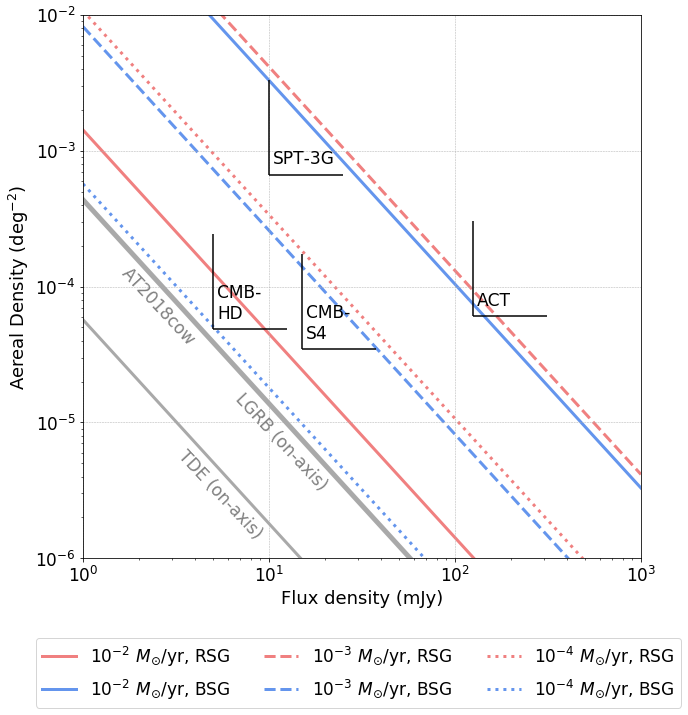

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
fv = np.logspace(-3,0,100)

prog_models = ['RSG','BSG']
colors = ['lightcoral', 'cornflowerblue']
t_IIn = day*np.arange(1,2000+1)
deg2_sky = 41253 # square degrees in whole sky
IIn_rate = 1.03e4 # Gpc^-3 yr -1

deg_label = np.rad2deg(np.arctan(3/2)) - 96

ds_ACT = 25 # mJy, personal communication with Kevin Huffenberger and Sigurd Naess
ads_ACT = 1/(0.4*deg2_sky) # per TOD, but surveys 40% of the sky with a weekly cadence...

ds_SPT = 2 # mJy, personal communication with Sam Gunns
ads_SPT = 1/(1500)

ds_CMBS4 = 3 # mJy # 1 week stack, wide survey (Abazajian 2019)
ads_CMBS4 = 1/(0.7*deg2_sky)

ds_CMBHD = 1 # mJy # 1 week stack, wide survey (Abazajian 2019)
ads_CMBHD = 1/(0.5*deg2_sky)

D = 100 * 1e6 * pc # pick some reference distance to draw the lines through
nu = 100e9
T = 1e4
E = 1e51
Mej = 5*Msun


for i in range(len(prog_models)):
    Fv = FFA_LC(t_IIn, nu, prog_models[i], 1e-2*(Msun/yr), T, E, Mej, n=10, s=2)/(4*np.pi*(D**2))
    half_pk, dt = half_peak(Fv, t_IIn)
    ad = IIn_rate*((100/1e3)**3)*(dt/365)*(1/deg2_sky)
    ads = ad*(half_pk/fv)**(3/2)
    plt.plot(fv*1000,ads, linewidth=3, color=colors[i], linestyle='-',
             label='$10^{-2}\ M_{\odot}$/yr, %s' %prog_models[i],zorder=1)
    
for i in range(len(prog_models)):
    Fv = FFA_LC(t_IIn, nu, prog_models[i], 1e-3*(Msun/yr), T, E, Mej, n=10, s=2)/(4*np.pi*(D**2))
    half_pk, dt = half_peak(Fv, t_IIn)
    ad = IIn_rate*((100/1e3)**3)*(dt/365)*(1/deg2_sky)
    ads = ad*(half_pk/fv)**(3/2)
    plt.plot(fv*1000,ads, linewidth=3, color=colors[i], linestyle='--',
             label='$10^{-3}\ M_{\odot}$/yr, %s' %prog_models[i],zorder=1)
    
for i in range(len(prog_models)):
    Fv = FFA_LC(t_IIn, nu, prog_models[i], 1e-4*(Msun/yr), T, E, Mej, n=10, s=2)/(4*np.pi*(D**2))
    half_pk, dt = half_peak(Fv, t_IIn)
    ad = IIn_rate*((100/1e3)**3)*(dt/365)*(1/deg2_sky)
    ads = ad*(half_pk/fv)**(3/2)
    plt.plot(fv*1000,ads, linewidth=3, color=colors[i], linestyle=':',
             label='$10^{-4}\ M_{\odot}$/yr, %s' %prog_models[i],zorder=1)
    

plt.yscale('log')
plt.xscale('log')
plt.xlim([np.min(fv*1000),np.max(fv*1000)])
plt.ylim([1e-6,1e-2])
plt.xticks(fontsize=17);
plt.yticks(fontsize=17);
plt.ylabel('Aereal Density (deg$^{-2}$)', fontsize=18);
plt.xlabel('Flux density (mJy)', fontsize=18);

det_sig = 5 # show instrument sensitivities with 5 sigma detection

plt.vlines(det_sig*ds_CMBS4,ymin=ads_CMBS4, ymax=5*ads_CMBS4, linestyle='-', color='k',zorder=10)
plt.hlines(ads_CMBS4,xmin=det_sig*ds_CMBS4, xmax=2.5*det_sig*ds_CMBS4, linestyle='-', color='k',zorder=10)
plt.text(1.05*det_sig*ds_CMBS4, 1.2*ads_CMBS4, 'CMB-\nS4', fontsize=17,zorder=10)

plt.vlines(det_sig*ds_CMBHD,ymin=ads_CMBHD, ymax=5*ads_CMBHD, linestyle='-', color='k',zorder=10)
plt.hlines(ads_CMBHD,xmin=det_sig*ds_CMBHD, xmax=2.5*det_sig*ds_CMBHD, linestyle='-', color='k',zorder=10)
plt.text(1.05*det_sig*ds_CMBHD, 1.2*ads_CMBHD, 'CMB-\nHD', fontsize=17,zorder=10)

plt.vlines(det_sig*ds_ACT,ymin=ads_ACT, ymax=5*ads_ACT, linestyle='-', color='k')
plt.hlines(ads_ACT,xmin=det_sig*ds_ACT, xmax=2.5*det_sig*ds_ACT, linestyle='-', color='k')
plt.text(1.05*det_sig*ds_ACT, 1.2*ads_ACT, 'ACT', fontsize=17)

plt.vlines(det_sig*ds_SPT,ymin=ads_SPT, ymax=5*ads_SPT, linestyle='-', color='k')
plt.hlines(ads_SPT,xmin=det_sig*ds_SPT, xmax=2.5*det_sig*ds_SPT, linestyle='-', color='k')
plt.text(1.05*det_sig*ds_SPT, 1.2*ads_SPT, 'SPT-3G', fontsize=17)

rot_angle = -47

lgrb_x, lgrb_y = lgrb()
plt.plot(lgrb_x, lgrb_y, color='darkgrey', linewidth=3)
plt.text(0.8*lgrb_x[30], 0.8*lgrb_y[30], 'LGRB (on-axis)', rotation=rot_angle, rotation_mode='anchor', color='grey', fontsize=17)

cow_x, cow_y = cow()
plt.plot(cow_x, cow_y, color='darkgrey', linewidth=3)
plt.text(0.8*cow_x[10], 0.8*cow_y[10], 'AT2018cow', rotation=rot_angle, rotation_mode='anchor', color='grey', fontsize=17)

tde_x, tde_y = tde()
plt.plot(tde_x, tde_y, color='darkgrey', linewidth=3)
plt.text(0.8*tde_x[20], 0.8*tde_y[20], 'TDE (on-axis)', rotation=rot_angle, rotation_mode='anchor', color='grey', fontsize=17)

plt.legend(bbox_to_anchor=(-0.1,-0.13), loc='upper left',fontsize=17, ncol=3)
plt.grid(axis = 'both', linestyle='--', linewidth=0.5)

if save_plots:
    plt.savefig('paper1_figures/rates_figure.pdf',bbox_inches='tight')
    plt.savefig('paper1_figures/rates_figure.png',bbox_inches='tight')